In [20]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np


In [8]:
RISKY_ASSET = 'AMZN'
START_DATE = '2010-12-31'
END_DATE = '2014-12-31'

In [9]:


# momentum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()
df_five_factor
asset_df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, 
                       #auto_adjust=True
                       progress=False)
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'


# join all datasets on the index
five_factor_data = df_five_factor.join(y)

# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 
                            'rf', 'rtn']

# divide everything (except returns) by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# select period of interest
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma', 
    data=five_factor_data
).fit()

print(five_factor_model.summary())

C:\Users\clint\AppData\Local\Temp\ipykernel_13588\720287180.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench',
C:\Users\clint\AppData\Local\Temp\ipykernel_13588\720287180.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench',
C:\Users\clint\AppData\Local\Temp\ipykernel_13588\720287180.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3',
C:\Users\c

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     3.334
Date:                Sat, 20 May 2023   Prob (F-statistic):             0.0126
Time:                        18:28:09   Log-Likelihood:                 66.019
No. Observations:                  48   AIC:                            -120.0
Df Residuals:                      42   BIC:                            -108.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0020      0.011      0.185      0.8

In [78]:
rf = five_factor_data['rf'].mean()
market_premium = five_factor_data['mkt'].mean()
smb_premium = five_factor_data['smb'].mean()
hml_premium = five_factor_data['hml'].mean()
rmw_premium=five_factor_data['rmw'].mean()
cma_premium=five_factor_data['cma'].mean()

intercept, b1, b2, b3,b4,b5 = five_factor_model.params

expected_monthly_return = rf + b1 * market_premium + b2 * smb_premium + b3 * hml_premium +b4 * rmw_premium + b5 * cma_premium 
expected_yearly_return = expected_monthly_return * 12
print("Expected yearly return:" + str(expected_yearly_return))


Expected yearly return:0.14425726740332626


In [80]:
five_factor_data.tail(10)




,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-03,0.0043,-0.0113,0.0493,0.0213,0.0198,0.0,-0.071058,-0.071058
2014-04,-0.0019,-0.0414,0.0117,0.0348,0.0104,0.0,-0.095847,-0.095847
2014-05,0.0206,-0.0189,-0.0013,0.0005,-0.0101,0.0,0.027685,0.027685
2014-06,0.0261,0.0310,-0.0070,-0.0189,-0.0198,0.0,0.039130,0.039130
2014-07,-0.0204,-0.0429,0.0003,0.0088,0.0051,0.0,-0.036302,-0.036302
2014-08,0.0424,0.0031,-0.0045,-0.0063,-0.0069,0.0,0.083229,0.083229
2014-09,-0.0197,-0.0373,-0.0134,0.0131,-0.0049,0.0,-0.048962,-0.048962
2014-10,0.0252,0.0372,-0.0181,-0.0055,-0.0009,0.0,-0.052661,-0.052661
2014-11,0.0255,-0.0228,-0.0309,0.0150,0.0026,0.0,0.108623,0.108623
2014-12,-0.0006,0.0286,0.0227,-0.0122,0.0096,0.0,-0.083688,-0.083688


Number of rows: 48


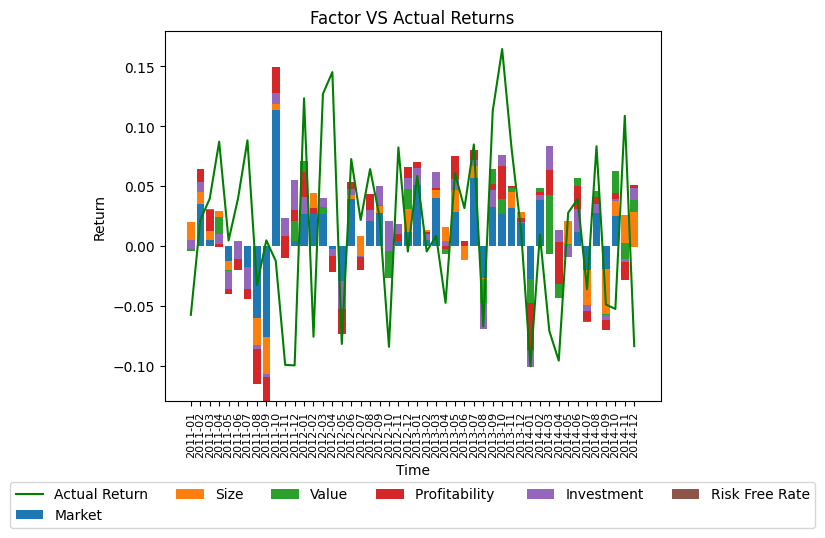

In [77]:
num_rows = len(five_factor_data)

print("Number of rows:", num_rows)
time=num_rows

categories = ['Market', 'Size', 'Value','Profitability ', 'Investment','Risk Free Rate']
time_periods = five_factor_data.index[:time].tolist()
data = np.array([five_factor_data['mkt'].tolist()[:time],  # mkt
                 five_factor_data['smb'].tolist()[:time],   # smb
                 five_factor_data['hml'].tolist()[:time],
                 five_factor_data['rmw'].tolist()[:time],   # Category 2
                 five_factor_data['cma'].tolist()[:time],
                 five_factor_data['rf'].tolist()[:time],   # cma
                 ])  

# Create stacked bar chart
fig, ax = plt.subplots()

# Plotting each category's bar
bottom = np.zeros(len(time_periods))
for i, category in enumerate(categories):
    ax.bar(time_periods, data[i], bottom=bottom, label=category)
    bottom += data[i]

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Return')
ax.set_title('Factor VS Actual Returns')
ax.legend()

# Calculate trend line
x = np.arange(len(time_periods))
y=five_factor_data['rtn'].tolist()[:time]

# Plot the trend line
ax.plot(x, y, color='green', label='Actual Return')
ax.legend()

# Set the legend below the graph
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(categories))

# Set the x-axis tick labels to display horizontally
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
# Display the chart
plt.show()
